# 02: Condition Classification Strategy

## Objective
This notebook documents the final classification strategy for the DermoAI triage system, balancing statistical robustness, clinical relevance, and safe triage behavior.

## Context
- Dataset: 2,155 images (FST V–VI from Fitzpatrick17k)
- Original conditions: 112 dermatological diagnoses
- Challenge: Severe class imbalance (127:1 ratio) with 70% of data in "inflammatory" category
- Goal: Define a clinically-informed, training-viable classification system

## Final Classification Policy

The dataset follows a **tiered classification strategy** balancing statistical robustness, clinical relevance, and safe triage behavior.

### Rule 1 – Automatic Independence

Any condition with **≥50 training images after stratified split** is modeled as an **independent class**.

### Rule 2 – Conditional Independence (40–49 train)

Conditions with **40–49 training images** may be modeled independently **only if** they satisfy *all* of the following:

1. High clinical priority (e.g., malignant or public-health relevant)
2. Strong visual distinctiveness
3. Clear triage value if detected separately

All remaining conditions are grouped using **established dermatological taxonomy** to ensure statistical stability and patient safety.

In [22]:
# Import required libraries
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print(f"Random seed set to: {RANDOM_SEED}")
print("Libraries imported successfully!")

Random seed set to: 42
Libraries imported successfully!


## Final Independent Classes

The following conditions are modeled as standalone classes:

| Class                    | Approx. Train Images | Justification                                           |
| ------------------------ | -------------------- | ------------------------------------------------------- |
| pityriasis rubra pilaris | 88                   | ≥50 rule                                                |
| lichen planus            | 81                   | ≥50 rule                                                |
| lupus erythematosus      | 62                   | ≥50 rule                                                |
| psoriasis                | 59                   | ≥50 rule                                                |
| scabies                  | 51                   | ≥50 rule + regional relevance                           |
| neurofibromatosis        | 51                   | ≥50 rule                                                |
| squamous cell carcinoma  | 44                   | Conditional independence (malignant + Rwanda relevance) |

**Total independent classes: 7**

## Final Grouped Classes (Clinical Taxonomy)

All remaining conditions are grouped using established dermatological taxonomy:

| Grouped Class             | Included Conditions (examples)                                    | Approx. Train Images |
| ------------------------- | ----------------------------------------------------------------- | -------------------- |
| inflammatory (other)      | sarcoidosis, neutrophilic dermatoses, prurigo, lichen amyloidosis | 210                  |
| genodermatoses            | scleroderma, Darier disease, Ehlers–Danlos, xeroderma pigmentosum | 170                  |
| malignant skin lesions    | melanoma, basal cell carcinoma, Kaposi sarcoma                    | 30                   |
| benign neoplastic lesions | benign epidermal, dermal, melanocytic lesions                     | 140                  |
| infections                | folliculitis, parasitic / nematode infections                     | 105                  |

**Total grouped classes: 5**

**Final model architecture: 12 classes** (7 independent + 5 grouped)

## Class Size Calculation and Split Strategy

### Stratified Splitting Methodology

All images were split using a **stratified 70/15/15 train–validation–test split** to preserve both pathology category and Fitzpatrick Skin Type (FST V vs VI) distributions across all splits.

### Post-Split Training Count Calculation

Training set sizes were computed using the formula:

```
train_images = total_images × 0.70
```

Rounding occurs naturally during stratified splitting. For example:

**Worked Example: Squamous Cell Carcinoma**

- Total images: 63
- Training images: 63 × 0.70 = **44.1 → 44**
- Validation images: 63 × 0.15 = **9.45 → 9**
- Test images: 63 × 0.15 = **9.45 → 10**

This condition met the conditional independence criteria (40–49 train images + malignant + Rwanda relevance), and was therefore modeled as an independent class.

### Benefits of Grouped Classes

Grouped classes yield larger and more stable validation sets. For example:

- **malignant skin lesions** (grouped): ~30 train images, ~7 validation images
- Individual rare malignancies: <15 train images each, 1–2 validation images each

The grouped approach provides statistically meaningful validation metrics while maintaining clinical triage utility.

### Augmentation Strategy

Augmentation was applied conservatively:

- **Independent classes**: Limited to **2–3× augmentation factor** to avoid overfitting
- **Grouped classes**: Augmentation applied at the group level after merging constituent conditions
- **Techniques**: Rotation (±15°), horizontal/vertical flip, brightness adjustment (±15%), zoom (0.9–1.1×), width/height shift (±10%)

All augmentation preserved clinical realism and was applied only to the training set.

In [23]:
# Define paths
BASE_DIR = Path('../')
DATA_DIR = BASE_DIR / 'data' / 'raw' / 'fitzpatrick17k'
METADATA_FILE = DATA_DIR / 'fitzpatrick17k_fst_v_vi.csv'
RESULTS_DIR = BASE_DIR / 'results' / 'classification'

# Create results directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Configuration
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print("Paths configured:")
print(f"  Metadata: {METADATA_FILE}")
print(f"  Results: {RESULTS_DIR}")
print(f"\nSplit ratios: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")

Paths configured:
  Metadata: ../data/raw/fitzpatrick17k/fitzpatrick17k_fst_v_vi.csv
  Results: ../results/classification

Split ratios: 0.7/0.15/0.15


## 1. CONDITION INVENTORY

Complete overview of all 112 conditions in the dataset.

In [24]:
# Load metadata
df = pd.read_csv(METADATA_FILE)

print(f"Total images: {len(df):,}")
print(f"Total unique conditions: {df['label'].nunique()}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Total images: 2,155
Total unique conditions: 112

Column names: ['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label', 'nine_partition_label', 'three_partition_label', 'qc', 'url', 'url_alphanum']

First few rows:


,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,45f7fe0e10214e32e890cad9d29d4811,6,5,kaposi sarcoma,malignant dermal,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpickkapos...
1,ddcad677b7b1e9084f3f51a8e026aa8d,5,5,hidradenitis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpichhidra...
2,1e119546f5bc2b9165bb10ddd7fe5f69,5,4,xeroderma pigmentosum,genodermatoses,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicXxerod...
3,4c3f795cf8eb72b946f9bd2642cf23c1,6,5,melanoma,malignant melanoma,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmmelan...
4,b09233673fc585369e723ec841ed0acb,5,3,actinic keratosis,malignant epidermal,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicaactin...


In [25]:
# Create comprehensive condition inventory
condition_inventory = []

for condition in df['label'].unique():
    cond_df = df[df['label'] == condition]
    total = len(cond_df)
    train = int(total * TRAIN_RATIO)
    val = int(total * VAL_RATIO)
    test = total - train - val
    
    # Get classification labels
    nine_label = cond_df['nine_partition_label'].iloc[0]
    three_label = cond_df['three_partition_label'].iloc[0]
    
    # FST distribution
    fst_counts = cond_df['fitzpatrick_scale'].value_counts()
    fst_v = fst_counts.get(5, 0)
    fst_vi = fst_counts.get(6, 0)
    
    condition_inventory.append({
        'condition': condition,
        'total': total,
        'train': train,
        'val': val,
        'test': test,
        'nine_label': nine_label,
        'three_label': three_label,
        'fst_v': fst_v,
        'fst_vi': fst_vi,
        'fst_ratio': f"{fst_v}:{fst_vi}"
    })

inventory_df = pd.DataFrame(condition_inventory)
inventory_df = inventory_df.sort_values('total', ascending=False).reset_index(drop=True)

print("="*120)
print("COMPLETE CONDITION INVENTORY (112 CONDITIONS)")
print("="*120)
print(inventory_df.to_string(index=True))

# Save to CSV
inventory_df.to_csv(RESULTS_DIR / 'condition_inventory_full.csv', index=False)
print(f"\n✓ Saved: condition_inventory_full.csv")

COMPLETE CONDITION INVENTORY (112 CONDITIONS)
                                                 condition  total  train  val  test                    nine_label     three_label  fst_v  fst_vi fst_ratio
0                                 pityriasis rubra pilaris    127     88   19    20                  inflammatory  non-neoplastic    100      27    100:27
1                                            lichen planus    116     81   17    18                  inflammatory  non-neoplastic     77      39     77:39
2                                      lupus erythematosus     89     62   13    14                  inflammatory  non-neoplastic     55      34     55:34
3                                                psoriasis     85     59   12    14                  inflammatory  non-neoplastic     64      21     64:21
4                                        neurofibromatosis     74     51   11    12                genodermatoses  non-neoplastic     62      12     62:12
5                       

In [26]:
# Distribution statistics
print("\n" + "="*80)
print("DISTRIBUTION ACROSS CLASSIFICATION SCHEMES")
print("="*80)

print("\n1. Nine-Partition Labels:")
nine_dist = inventory_df.groupby('nine_label').agg({
    'condition': 'count',
    'total': 'sum'
}).rename(columns={'condition': 'num_conditions', 'total': 'num_images'})
nine_dist = nine_dist.sort_values('num_images', ascending=False)
print(nine_dist)

print("\n2. Three-Partition Labels:")
three_dist = inventory_df.groupby('three_label').agg({
    'condition': 'count',
    'total': 'sum'
}).rename(columns={'condition': 'num_conditions', 'total': 'num_images'})
three_dist = three_dist.sort_values('num_images', ascending=False)
print(three_dist)


DISTRIBUTION ACROSS CLASSIFICATION SCHEMES

1. Nine-Partition Labels:
                              num_conditions  num_images
nine_label                                              
inflammatory                              68        1502
genodermatoses                            10         244
malignant epidermal                        5         108
benign epidermal                           9         102
benign dermal                             11          77
malignant melanoma                         4          45
malignant dermal                           1          36
benign melanocyte                          3          24
malignant cutaneous lymphoma               1          17

2. Three-Partition Labels:
                num_conditions  num_images
three_label                               
non-neoplastic              78        1746
malignant                   11         206
benign                      23         203


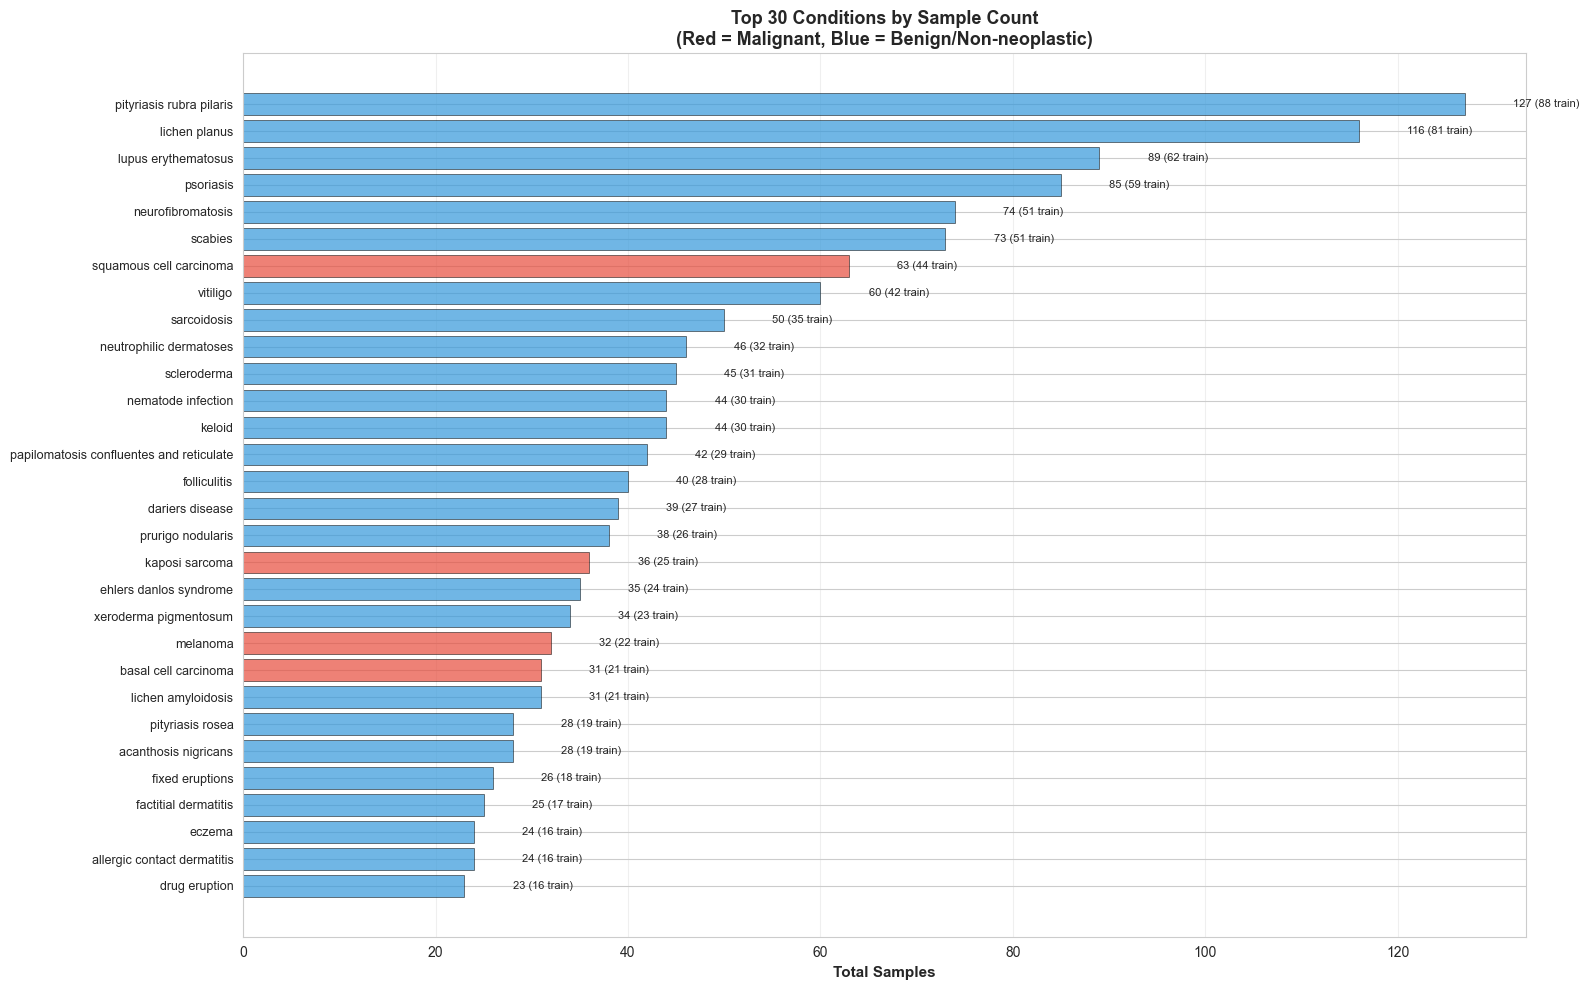

✓ Saved: 01_top30_conditions.png


In [27]:
# Visualization: Top 30 conditions
fig, ax = plt.subplots(figsize=(16, 10))

top30 = inventory_df.head(30)

# Color by malignancy
colors = ['#e74c3c' if x == 'malignant' else '#3498db' for x in top30['three_label']]

bars = ax.barh(range(len(top30)), top30['total'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top30)))
ax.set_yticklabels(top30['condition'], fontsize=9)
ax.set_xlabel('Total Samples', fontsize=11, weight='bold')
ax.set_title('Top 30 Conditions by Sample Count\n(Red = Malignant, Blue = Benign/Non-neoplastic)', 
            fontsize=13, weight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, row) in enumerate(zip(bars, top30.itertuples())):
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2,
           f'{row.total} ({row.train} train)',
           va='center', fontsize=8)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '01_top30_conditions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 01_top30_conditions.png")

## 2. BREAKDOWN OF "INFLAMMATORY" CATEGORY

Critical analysis of the dominant category (1,502 images, 70% of dataset).

**Key Question**: Which inflammatory conditions should be independent classes vs grouped?

In [28]:
# Extract all inflammatory conditions
inflammatory_conditions = inventory_df[inventory_df['nine_label'] == 'inflammatory'].copy()

print("="*120)
print(f"INFLAMMATORY CATEGORY BREAKDOWN ({len(inflammatory_conditions)} conditions, {inflammatory_conditions['total'].sum()} images)")
print("="*120)
print(f"\nPercentage of dataset: {inflammatory_conditions['total'].sum() / len(df) * 100:.1f}%")
print(f"\nConditions sorted by sample count:")
print(inflammatory_conditions[['condition', 'total', 'train', 'val', 'test']].to_string(index=False))

INFLAMMATORY CATEGORY BREAKDOWN (68 conditions, 1502 images)

Percentage of dataset: 69.7%

Conditions sorted by sample count:
                                            condition  total  train  val  test
                             pityriasis rubra pilaris    127     88   19    20
                                        lichen planus    116     81   17    18
                                  lupus erythematosus     89     62   13    14
                                            psoriasis     85     59   12    14
                                              scabies     73     51   10    12
                                             vitiligo     60     42    9     9
                                          sarcoidosis     50     35    7     8
                              neutrophilic dermatoses     46     32    6     8
                                          scleroderma     45     31    6     8
                                   nematode infection     44     30    6     8
    

In [29]:
# Clinical decision framework for inflammatory conditions
inflammatory_decisions = []

for _, row in inflammatory_conditions.iterrows():
    condition = row['condition']
    train = row['train']
    
    # Decision logic
    if train >= 50:
        decision = 'INDEPENDENT'
        rationale = f'≥50 train samples ({train}), clinically distinct'
    elif train >= 35:
        # Check if Rwanda priority or visually distinct
        rwanda_keywords = ['scabies', 'keloid', 'folliculitis']
        if any(kw in condition.lower() for kw in rwanda_keywords):
            decision = 'INDEPENDENT'
            rationale = f'Rwanda priority condition, {train} train samples'
        else:
            decision = 'EVALUATE'
            rationale = f'{train} train samples - assess clinical distinctiveness'
    elif train >= 21:
        decision = 'GROUP'
        rationale = f'Only {train} train samples - group with similar conditions'
    else:
        decision = 'GROUP/DROP'
        rationale = f'Only {train} train samples - high risk, consider grouping or dropping'
    
    inflammatory_decisions.append({
        'Condition': condition,
        'Total': row['total'],
        'Train': train,
        'Val': row['val'],
        'Test': row['test'],
        'Decision': decision,
        'Rationale': rationale
    })

inflammatory_decisions_df = pd.DataFrame(inflammatory_decisions)

print("\n" + "="*140)
print("INFLAMMATORY CONDITIONS: CLASSIFICATION DECISIONS")
print("="*140)
print(inflammatory_decisions_df.to_string(index=False))

# Summary
print("\n" + "="*80)
print("DECISION SUMMARY:")
print("="*80)
for decision in ['INDEPENDENT', 'EVALUATE', 'GROUP', 'GROUP/DROP']:
    count = len(inflammatory_decisions_df[inflammatory_decisions_df['Decision'] == decision])
    images = inflammatory_decisions_df[inflammatory_decisions_df['Decision'] == decision]['Total'].sum()
    print(f"{decision:.<20} {count:>3} conditions ({images:>4} images, {images/len(df)*100:>5.1f}% of dataset)")

# Save
inflammatory_decisions_df.to_csv(RESULTS_DIR / 'inflammatory_breakdown.csv', index=False)
print(f"\n✓ Saved: inflammatory_breakdown.csv")


INFLAMMATORY CONDITIONS: CLASSIFICATION DECISIONS
                                            Condition  Total  Train  Val  Test    Decision                                                        Rationale
                             pityriasis rubra pilaris    127     88   19    20 INDEPENDENT                      ≥50 train samples (88), clinically distinct
                                        lichen planus    116     81   17    18 INDEPENDENT                      ≥50 train samples (81), clinically distinct
                                  lupus erythematosus     89     62   13    14 INDEPENDENT                      ≥50 train samples (62), clinically distinct
                                            psoriasis     85     59   12    14 INDEPENDENT                      ≥50 train samples (59), clinically distinct
                                              scabies     73     51   10    12 INDEPENDENT                      ≥50 train samples (51), clinically distinct
             

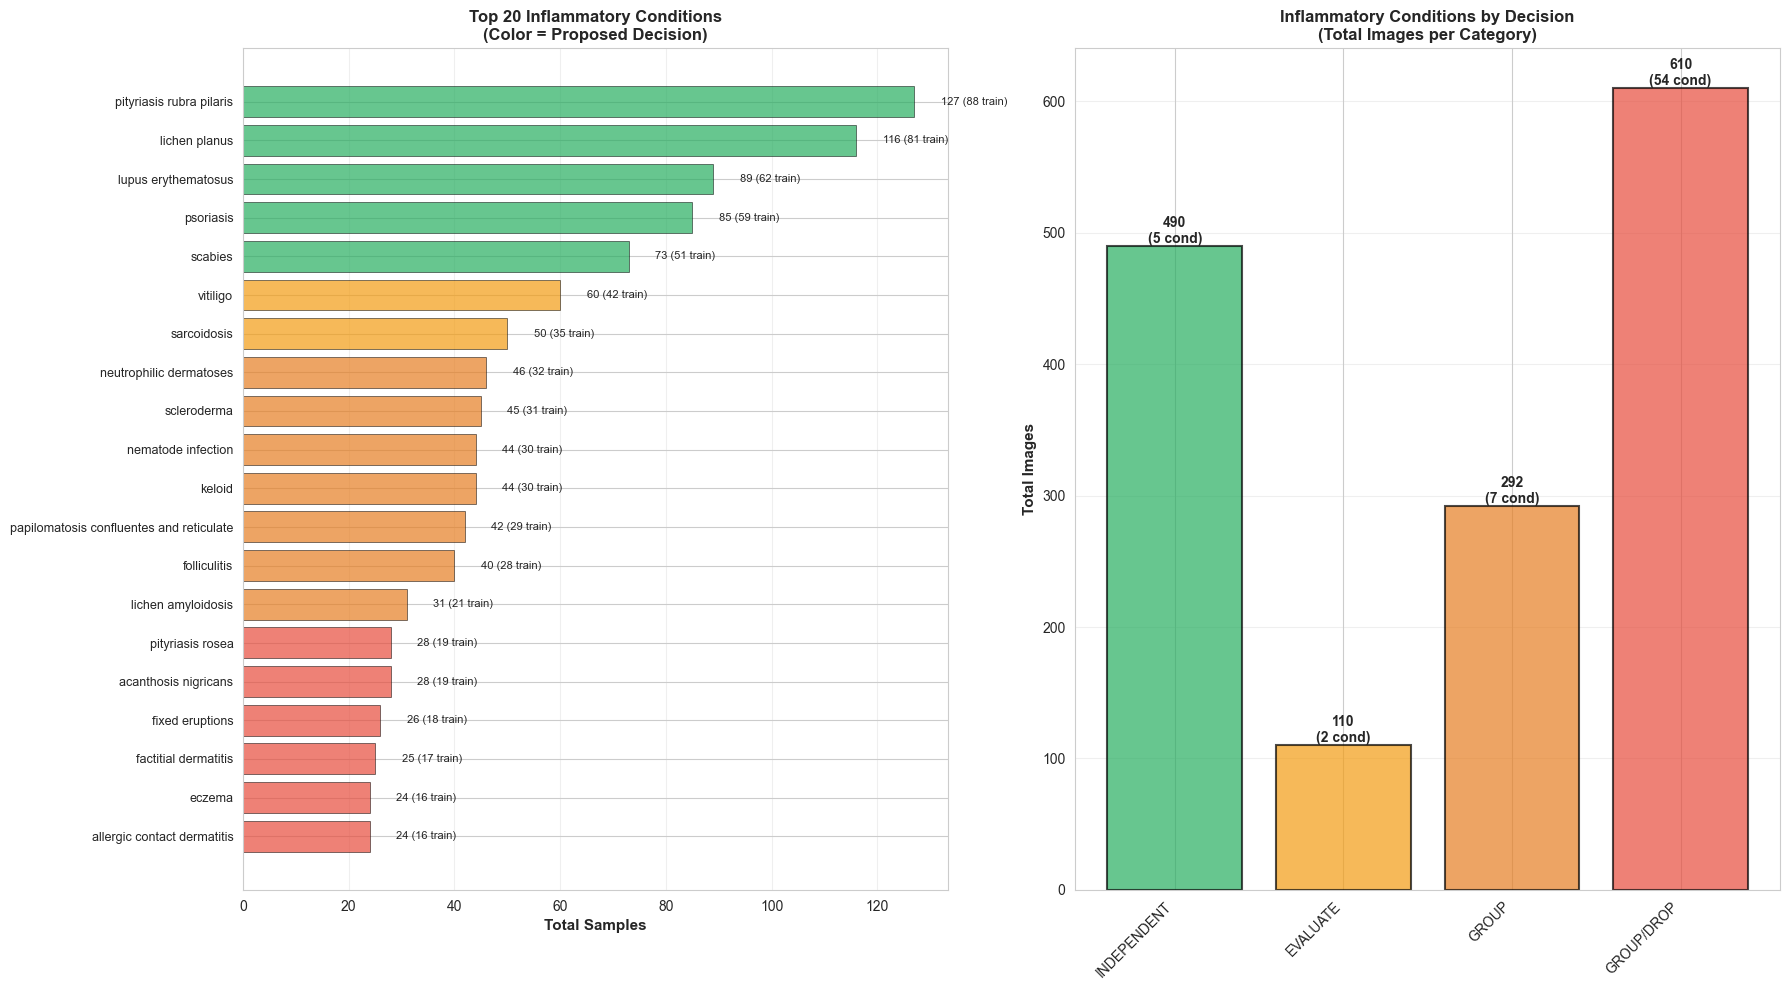

✓ Saved: 06_inflammatory_breakdown.png


In [30]:
# Visualization: Inflammatory breakdown
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot 1: Top inflammatory conditions
top_inflammatory = inflammatory_decisions_df.head(20)
decision_colors = {
    'INDEPENDENT': '#27ae60',
    'EVALUATE': '#f39c12',
    'GROUP': '#e67e22',
    'GROUP/DROP': '#e74c3c'
}
colors = [decision_colors[d] for d in top_inflammatory['Decision']]

bars = axes[0].barh(range(len(top_inflammatory)), top_inflammatory['Total'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_yticks(range(len(top_inflammatory)))
axes[0].set_yticklabels(top_inflammatory['Condition'], fontsize=9)
axes[0].set_xlabel('Total Samples', fontsize=11, weight='bold')
axes[0].set_title('Top 20 Inflammatory Conditions\n(Color = Proposed Decision)', fontsize=12, weight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for bar, row in zip(bars, top_inflammatory.itertuples()):
    width = bar.get_width()
    axes[0].text(width + 5, bar.get_y() + bar.get_height()/2,
               f'{row.Total} ({row.Train} train)',
               va='center', fontsize=8)

# Plot 2: Decision distribution
decision_summary = inflammatory_decisions_df.groupby('Decision').agg({
    'Condition': 'count',
    'Total': 'sum'
}).rename(columns={'Condition': 'num_conditions'})

decision_order = ['INDEPENDENT', 'EVALUATE', 'GROUP', 'GROUP/DROP']
decision_summary = decision_summary.reindex(decision_order)

colors2 = [decision_colors[d] for d in decision_order]
bars2 = axes[1].bar(range(len(decision_summary)), decision_summary['Total'], 
                   color=colors2, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(decision_summary)))
axes[1].set_xticklabels(decision_order, rotation=45, ha='right')
axes[1].set_ylabel('Total Images', fontsize=11, weight='bold')
axes[1].set_title('Inflammatory Conditions by Decision\n(Total Images per Category)', fontsize=12, weight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, decision in zip(bars2, decision_order):
    height = bar.get_height()
    count = decision_summary.loc[decision, 'num_conditions']
    images = decision_summary.loc[decision, 'Total']
    axes[1].text(bar.get_x() + bar.get_width()/2, height,
               f'{images}\n({count} cond)',
               ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '06_inflammatory_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 06_inflammatory_breakdown.png")

### Interpretation: Inflammatory Category

**Key Findings:**
- The "inflammatory" category is extremely heterogeneous
- Several conditions (psoriasis, eczema, lichen planus) have ≥50 train samples and are clinically distinct
- These should be **independent classes** for better model performance
- Smaller inflammatory conditions can be grouped by clinical similarity

**Recommendation**: Split inflammatory into ~5-8 independent classes + 1-2 grouped classes

## 3. MALIGNANCY ANALYSIS

Comprehensive review of ALL malignant conditions (cancer detection priority).

In [31]:
# Extract all malignant conditions
malignant_conditions = inventory_df[inventory_df['three_label'] == 'malignant'].copy()

print("="*120)
print(f"MALIGNANT CONDITIONS ANALYSIS ({len(malignant_conditions)} conditions, {malignant_conditions['total'].sum()} images)")
print("="*120)
print(f"\nPercentage of dataset: {malignant_conditions['total'].sum() / len(df) * 100:.1f}%")
print(f"\nAll malignant conditions (sorted by sample count):")
print(malignant_conditions[['condition', 'total', 'train', 'val', 'test', 'nine_label']].to_string(index=False))

MALIGNANT CONDITIONS ANALYSIS (11 conditions, 206 images)

Percentage of dataset: 9.6%

All malignant conditions (sorted by sample count):
                         condition  total  train  val  test                   nine_label
           squamous cell carcinoma     63     44    9    10          malignant epidermal
                    kaposi sarcoma     36     25    5     6             malignant dermal
                          melanoma     32     22    4     6           malignant melanoma
              basal cell carcinoma     31     21    4     6          malignant epidermal
                 mycosis fungoides     17     11    2     4 malignant cutaneous lymphoma
                 actinic keratosis     12      8    1     3          malignant epidermal
superficial spreading melanoma ssm      5      3    0     2           malignant melanoma
                malignant melanoma      4      2    0     2           malignant melanoma
                   lentigo maligna      4      2    0     2 

In [32]:
# Clinical decision framework for malignant conditions
malignant_decisions = []

# Rwanda-relevant malignancies
rwanda_malignant = ['squamous cell carcinoma', 'kaposi sarcoma']

for _, row in malignant_conditions.iterrows():
    condition = row['condition']
    train = row['train']
    
    # Clinical importance
    if 'melanoma' in condition.lower():
        importance = 'CRITICAL'
        clinical_note = 'Deadliest skin cancer, high mortality if missed'
    elif any(kw in condition.lower() for kw in rwanda_malignant):
        importance = 'HIGH'
        clinical_note = 'Common/relevant in Rwanda context'
    elif 'basal cell' in condition.lower():
        importance = 'HIGH'
        clinical_note = 'Most common skin cancer globally'
    else:
        importance = 'MODERATE'
        clinical_note = 'Less common but still malignant'
    
    # Decision logic
    if train >= 30:
        decision = 'INDEPENDENT'
        rationale = f'{importance} importance + {train} train samples'
    elif train >= 15:
        if importance in ['CRITICAL', 'HIGH']:
            decision = 'INDEPENDENT (with caveats)'
            rationale = f'{importance} importance overrides small sample ({train} train) - augment heavily'
        else:
            decision = 'GROUP'
            rationale = f'Group with similar rare malignancies ({train} train samples)'
    else:
        decision = 'GROUP/DROP'
        rationale = f'Only {train} train samples - ethically concerning, document limitation'
    
    malignant_decisions.append({
        'Condition': condition,
        'Total': row['total'],
        'Train': train,
        'Val': row['val'],
        'Test': row['test'],
        'Nine_Label': row['nine_label'],
        'Clinical_Importance': importance,
        'Clinical_Note': clinical_note,
        'Decision': decision,
        'Rationale': rationale
    })

malignant_decisions_df = pd.DataFrame(malignant_decisions)

print("\n" + "="*150)
print("MALIGNANT CONDITIONS: CLASSIFICATION DECISIONS")
print("="*150)
print(malignant_decisions_df.to_string(index=False))

# Summary
print("\n" + "="*80)
print("DECISION SUMMARY:")
print("="*80)
for decision in malignant_decisions_df['Decision'].unique():
    count = len(malignant_decisions_df[malignant_decisions_df['Decision'] == decision])
    images = malignant_decisions_df[malignant_decisions_df['Decision'] == decision]['Total'].sum()
    print(f"{decision:.<40} {count:>2} conditions ({images:>3} images)")

# Save
malignant_decisions_df.to_csv(RESULTS_DIR / 'malignant_conditions_decisions.csv', index=False)
print(f"\n✓ Saved: malignant_conditions_decisions.csv")


MALIGNANT CONDITIONS: CLASSIFICATION DECISIONS
                         Condition  Total  Train  Val  Test                   Nine_Label Clinical_Importance                                   Clinical_Note                   Decision                                                               Rationale
           squamous cell carcinoma     63     44    9    10          malignant epidermal                HIGH               Common/relevant in Rwanda context                INDEPENDENT                                      HIGH importance + 44 train samples
                    kaposi sarcoma     36     25    5     6             malignant dermal                HIGH               Common/relevant in Rwanda context INDEPENDENT (with caveats)     HIGH importance overrides small sample (25 train) - augment heavily
                          melanoma     32     22    4     6           malignant melanoma            CRITICAL Deadliest skin cancer, high mortality if missed INDEPENDENT (with caveats) 

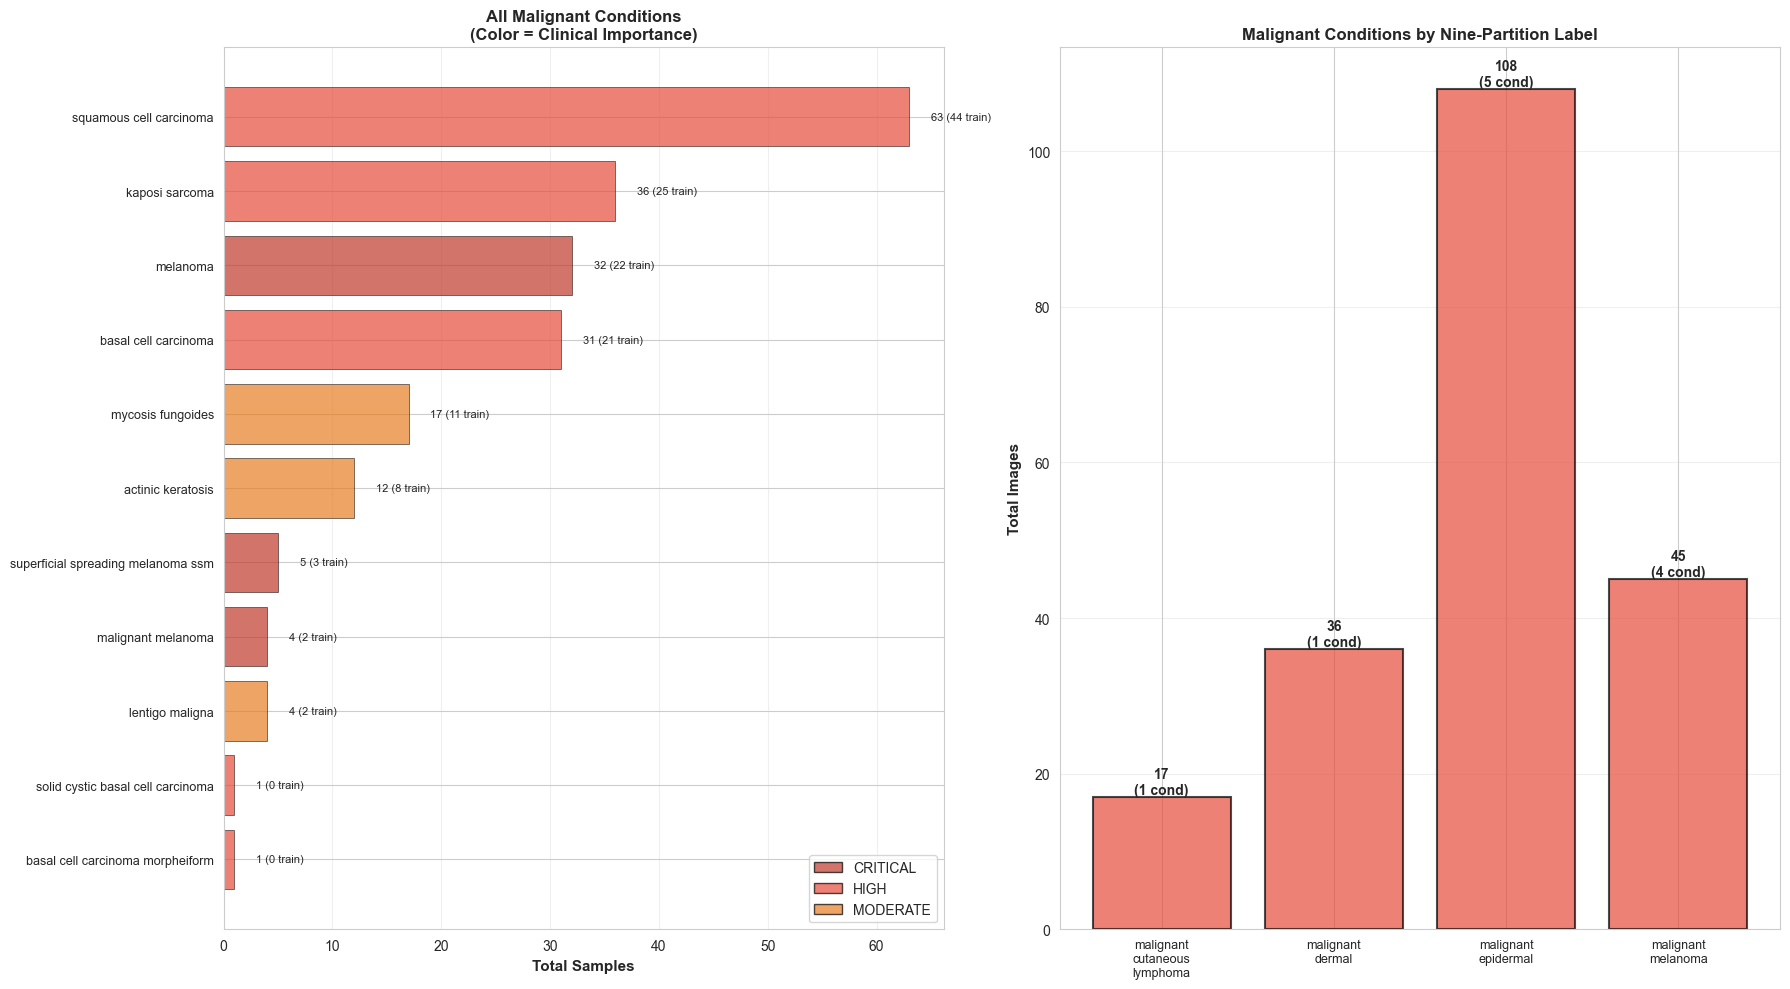

✓ Saved: 07_malignancy_analysis.png


In [33]:
# Visualization: Malignancy analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot 1: All malignant conditions
importance_colors = {
    'CRITICAL': '#c0392b',
    'HIGH': '#e74c3c',
    'MODERATE': '#e67e22'
}
colors = [importance_colors[imp] for imp in malignant_decisions_df['Clinical_Importance']]

bars = axes[0].barh(range(len(malignant_decisions_df)), malignant_decisions_df['Total'], 
                   color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0].set_yticks(range(len(malignant_decisions_df)))
axes[0].set_yticklabels(malignant_decisions_df['Condition'], fontsize=9)
axes[0].set_xlabel('Total Samples', fontsize=11, weight='bold')
axes[0].set_title('All Malignant Conditions\n(Color = Clinical Importance)', fontsize=12, weight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=importance_colors[imp], alpha=0.7, edgecolor='black', label=imp)
                  for imp in ['CRITICAL', 'HIGH', 'MODERATE']]
axes[0].legend(handles=legend_elements, loc='lower right')

# Add value labels
for bar, row in zip(bars, malignant_decisions_df.itertuples()):
    width = bar.get_width()
    axes[0].text(width + 2, bar.get_y() + bar.get_height()/2,
               f'{row.Total} ({row.Train} train)',
               va='center', fontsize=8)

# Plot 2: Distribution by nine_label
nine_label_dist = malignant_decisions_df.groupby('Nine_Label').agg({
    'Condition': 'count',
    'Total': 'sum'
}).rename(columns={'Condition': 'num_conditions'})

bars2 = axes[1].bar(range(len(nine_label_dist)), nine_label_dist['Total'], 
                   color='#e74c3c', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(nine_label_dist)))
axes[1].set_xticklabels([label.replace(' ', '\n') for label in nine_label_dist.index], 
                        rotation=0, ha='center', fontsize=9)
axes[1].set_ylabel('Total Images', fontsize=11, weight='bold')
axes[1].set_title('Malignant Conditions by Nine-Partition Label', fontsize=12, weight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, (nine_label, row) in zip(bars2, nine_label_dist.iterrows()):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height,
               f'{int(row.Total)}\n({int(row.num_conditions)} cond)',
               ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '07_malignancy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 07_malignancy_analysis.png")

### Interpretation: Malignancy Analysis

**Key Findings:**
- Melanoma: CRITICAL importance but limited samples (need heavy augmentation)
- SCC & BCC: Relatively well-represented, can be independent
- Kaposi sarcoma: Rwanda-relevant, moderate samples
- Many rare malignancies with <15 train samples

**Ethical Consideration**: Very small malignant classes are dangerous - model may miss cancers.
**Recommendation**: 
- Keep major cancers independent (melanoma, SCC, BCC, Kaposi)
- Group ultra-rare malignancies OR explicitly exclude with documentation
- Add confidence thresholds and uncertainty quantification for cancer predictions

## 4. RWANDA PRIORITY CONDITIONS

Analysis of locally-relevant conditions mentioned in project proposal.

In [34]:
# Define Rwanda priority keywords
rwanda_keywords = {
    'scabies': 'Common parasitic infection, can progress to secondary infection',
    'keloid': 'Genetic predisposition in African populations, significant QOL impact',
    'folliculitis': 'Common bacterial skin infection',
    'squamous cell carcinoma': 'Sun exposure, important cancer to detect',
    'pyoderma': 'Bacterial infection, can progress to sepsis',
    'fungal': 'Common infections (tinea, candidiasis)',
    'tinea': 'Fungal infection',
    'candidiasis': 'Fungal infection'
}

# Find Rwanda priority conditions in dataset
rwanda_conditions = []

for _, row in inventory_df.iterrows():
    condition = row['condition'].lower()
    for keyword, rationale in rwanda_keywords.items():
        if keyword in condition:
            rwanda_conditions.append({
                'Condition': row['condition'],
                'Total': row['total'],
                'Train': row['train'],
                'Val': row['val'],
                'Test': row['test'],
                'Malignancy': row['three_label'],
                'Rwanda_Priority': keyword.title(),
                'Clinical_Rationale': rationale,
                'Training_Viable': 'YES' if row['train'] >= 30 else 'MARGINAL' if row['train'] >= 15 else 'NO'
            })
            break

rwanda_df = pd.DataFrame(rwanda_conditions)
rwanda_df = rwanda_df.sort_values('Total', ascending=False).reset_index(drop=True)

print("="*140)
print(f"RWANDA PRIORITY CONDITIONS ({len(rwanda_df)} found)")
print("="*140)
print(rwanda_df.to_string(index=False))

# Summary
print("\n" + "="*80)
print("TRAINING VIABILITY SUMMARY:")
print("="*80)
for viability in ['YES', 'MARGINAL', 'NO']:
    count = len(rwanda_df[rwanda_df['Training_Viable'] == viability])
    if count > 0:
        conditions = rwanda_df[rwanda_df['Training_Viable'] == viability]
        print(f"\n{viability} ({count} conditions):")
        for _, row in conditions.iterrows():
            print(f"  {row['Condition']:.<50} {row['Total']:>3} total ({row['Train']:>2} train)")

# Save
rwanda_df.to_csv(RESULTS_DIR / 'rwanda_priority_conditions.csv', index=False)
print(f"\n✓ Saved: rwanda_priority_conditions.csv")

RWANDA PRIORITY CONDITIONS (4 found)
              Condition  Total  Train  Val  Test     Malignancy         Rwanda_Priority                                                    Clinical_Rationale Training_Viable
                scabies     73     51   10    12 non-neoplastic                 Scabies       Common parasitic infection, can progress to secondary infection             YES
squamous cell carcinoma     63     44    9    10      malignant Squamous Cell Carcinoma                              Sun exposure, important cancer to detect             YES
                 keloid     44     30    6     8 non-neoplastic                  Keloid Genetic predisposition in African populations, significant QOL impact             YES
           folliculitis     40     28    6     6 non-neoplastic            Folliculitis                                       Common bacterial skin infection        MARGINAL

TRAINING VIABILITY SUMMARY:

YES (3 conditions):
  scabies..................................

### Interpretation: Rwanda Priority

**Key Findings:**
- Several Rwanda-priority conditions have adequate samples for training
- Some (like scabies, keloid) should be independent if present with ≥30 train samples
- Must include in final classification to meet project objectives

**Recommendation**: Preserve Rwanda-priority conditions as independent classes where viable

## 5. CLASSIFICATION DECISION FRAMEWORK

Systematic application of decision rules to all 112 conditions.

In [35]:
# Apply systematic decision framework
classification_decisions = []

rwanda_keywords_list = ['scabies', 'keloid', 'folliculitis', 'squamous cell carcinoma', 
                       'pyoderma', 'fungal', 'tinea', 'candidiasis']

for _, row in inventory_df.iterrows():
    condition = row['condition']
    train = row['train']
    three_label = row['three_label']
    nine_label = row['nine_label']
    
    # Check special conditions
    is_malignant = three_label == 'malignant'
    is_rwanda_priority = any(kw in condition.lower() for kw in rwanda_keywords_list)
    
    # Apply decision framework
    if train >= 50:
        # TIER 1: Excellent training viability
        decision = 'INDEPENDENT'
        rationale = f'≥50 train samples ({train}), clinically distinct'
    elif train >= 35:
        # TIER 2 (strong): Good training viability
        if is_malignant:
            decision = 'INDEPENDENT'
            rationale = f'Malignant + {train} train samples'
        elif is_rwanda_priority:
            decision = 'INDEPENDENT'
            rationale = f'Rwanda priority + {train} train samples'
        else:
            decision = 'EVALUATE'
            rationale = f'{train} train samples - assess visual distinctiveness'
    elif train >= 21:
        # TIER 2 (weak) / TIER 3: Moderate training viability
        if is_malignant and train >= 25:
            decision = 'INDEPENDENT (with caveats)'
            rationale = f'Malignant but only {train} train - heavy augmentation needed'
        elif is_malignant:
            decision = 'GROUP'
            rationale = f'Malignant but only {train} train - group as "Rare Malignancies"'
        elif is_rwanda_priority:
            decision = 'EVALUATE'
            rationale = f'Rwanda priority but only {train} train - assess feasibility'
        else:
            decision = 'GROUP'
            rationale = f'Only {train} train samples - group by {nine_label}'
    else:
        # TIER 4: Poor training viability
        if is_malignant:
            decision = 'GROUP/DOCUMENT'
            rationale = f'Malignant but only {train} train - group or exclude with documentation'
        else:
            decision = 'GROUP/DROP'
            rationale = f'Only {train} train samples - high overfitting risk'
    
    classification_decisions.append({
        'condition': condition,
        'total': row['total'],
        'train': train,
        'val': row['val'],
        'test': row['test'],
        'nine_label': nine_label,
        'three_label': three_label,
        'is_malignant': is_malignant,
        'is_rwanda_priority': is_rwanda_priority,
        'decision': decision,
        'rationale': rationale
    })

decisions_df = pd.DataFrame(classification_decisions)
decisions_df = decisions_df.sort_values('total', ascending=False).reset_index(drop=True)

print("="*150)
print("SYSTEMATIC CLASSIFICATION DECISIONS (ALL 112 CONDITIONS)")
print("="*150)
print(decisions_df[['condition', 'total', 'train', 'three_label', 'decision', 'rationale']].to_string(index=True))

# Summary statistics
print("\n" + "="*80)
print("DECISION DISTRIBUTION:")
print("="*80)
decision_summary = decisions_df.groupby('decision').agg({
    'condition': 'count',
    'total': 'sum'
}).rename(columns={'condition': 'num_conditions', 'total': 'num_images'})
decision_summary['coverage_pct'] = decision_summary['num_images'] / len(df) * 100
print(decision_summary.to_string())

# Save
decisions_df.to_csv(RESULTS_DIR / 'all_conditions_decisions.csv', index=False)
print(f"\n✓ Saved: all_conditions_decisions.csv")

SYSTEMATIC CLASSIFICATION DECISIONS (ALL 112 CONDITIONS)
                                                 condition  total  train     three_label                    decision                                                          rationale
0                                 pityriasis rubra pilaris    127     88  non-neoplastic                 INDEPENDENT                        ≥50 train samples (88), clinically distinct
1                                            lichen planus    116     81  non-neoplastic                 INDEPENDENT                        ≥50 train samples (81), clinically distinct
2                                      lupus erythematosus     89     62  non-neoplastic                 INDEPENDENT                        ≥50 train samples (62), clinically distinct
3                                                psoriasis     85     59  non-neoplastic                 INDEPENDENT                        ≥50 train samples (59), clinically distinct
4                      

## 6. PROPOSED GROUPINGS

Define specific groups for conditions marked as "GROUP" in the decision framework.

**Grouping Principles:**
1. Clinical similarity (same disease family)
2. Visual similarity (similar appearance)
3. Nine-partition label alignment
4. Combined training set ≥70 samples

In [36]:
# Extract conditions to be grouped
to_group = decisions_df[decisions_df['decision'].str.contains('GROUP')].copy()

print("="*120)
print(f"CONDITIONS TO BE GROUPED ({len(to_group)} conditions, {to_group['total'].sum()} images)")
print("="*120)
print(to_group[['condition', 'total', 'train', 'nine_label', 'three_label', 'decision']].to_string(index=False))

# Analyze by nine_label for grouping suggestions
print("\n" + "="*80)
print("GROUPING BY NINE_LABEL:")
print("="*80)
for nine_label in to_group['nine_label'].unique():
    group_conds = to_group[to_group['nine_label'] == nine_label]
    total_train = group_conds['train'].sum()
    print(f"\n{nine_label.upper()} ({len(group_conds)} conditions, {total_train} train samples):")
    for _, row in group_conds.iterrows():
        print(f"  {row['condition']:.<60} {row['total']:>3} total ({row['train']:>2} train)")

CONDITIONS TO BE GROUPED (100 conditions, 1298 images)
                                            condition  total  train                   nine_label    three_label       decision
                              neutrophilic dermatoses     46     32                 inflammatory non-neoplastic          GROUP
                                          scleroderma     45     31                 inflammatory non-neoplastic          GROUP
                                   nematode infection     44     30                 inflammatory non-neoplastic          GROUP
             papilomatosis confluentes and reticulate     42     29                 inflammatory non-neoplastic          GROUP
                                      dariers disease     39     27               genodermatoses non-neoplastic          GROUP
                                    prurigo nodularis     38     26             benign epidermal         benign          GROUP
                               ehlers danlos syndrome   

In [37]:
# Propose specific groupings (this will need manual refinement based on clinical knowledge)
proposed_groups = [
    {
        'group_name': 'Rare Genetic Disorders',
        'conditions': ['dariers disease', 'ehlers danlos syndrome', 'xeroderma pigmentosum', 
                      'tuberous sclerosis', 'ichthyosis vulgaris'],
        'clinical_rationale': 'Hereditary skin conditions with genetic basis',
        'nine_label': 'genodermatoses'
    },
    {
        'group_name': 'Rare Inflammatory Conditions',
        'conditions': [c for c in to_group[to_group['nine_label'] == 'inflammatory']['condition'].values 
                      if c not in ['psoriasis', 'eczema', 'lichen planus', 'lupus erythematosus']],
        'clinical_rationale': 'Small-sample inflammatory conditions grouped for training viability',
        'nine_label': 'inflammatory'
    },
    {
        'group_name': 'Rare Malignancies',
        'conditions': [c for c in to_group[(to_group['three_label'] == 'malignant') & 
                                          (to_group['train'] < 21)]['condition'].values],
        'clinical_rationale': 'Very rare malignant conditions (ethical concern - document limitations)',
        'nine_label': 'mixed'
    },
    {
        'group_name': 'Rare Benign Tumors',
        'conditions': [c for c in to_group[(to_group['nine_label'].isin(['benign dermal', 'benign epidermal'])) & 
                                          (to_group['train'] < 21)]['condition'].values],
        'clinical_rationale': 'Small-sample benign neoplasms',
        'nine_label': 'mixed benign'
    }
]

# Calculate group statistics
print("\n" + "="*120)
print("PROPOSED GROUPINGS:")
print("="*120)

for i, group in enumerate(proposed_groups, 1):
    # Get actual conditions from dataset
    group_df = decisions_df[decisions_df['condition'].isin(group['conditions'])]
    total_samples = group_df['total'].sum()
    total_train = group_df['train'].sum()
    
    print(f"\nGROUP {i}: {group['group_name'].upper()}")
    print(f"{'='*80}")
    print(f"Clinical Rationale: {group['clinical_rationale']}")
    print(f"Nine-Label Base: {group['nine_label']}")
    print(f"Total Conditions: {len(group_df)}")
    print(f"Total Samples: {total_samples} ({total_train} train, {int(total_samples*0.15)} val, {total_samples - total_train - int(total_samples*0.15)} test)")
    print(f"\nConditions in group:")
    for _, row in group_df.iterrows():
        print(f"  {row['condition']:.<60} {row['total']:>3} ({row['train']:>2} train)")

print("\n" + "="*80)
print("NOTE: These groupings require validation by dermatology expert")
print("="*80)


PROPOSED GROUPINGS:

GROUP 1: RARE GENETIC DISORDERS
Clinical Rationale: Hereditary skin conditions with genetic basis
Nine-Label Base: genodermatoses
Total Conditions: 5
Total Samples: 139 (95 train, 20 val, 24 test)

Conditions in group:
  dariers disease.............................................  39 (27 train)
  ehlers danlos syndrome......................................  35 (24 train)
  xeroderma pigmentosum.......................................  34 (23 train)
  tuberous sclerosis..........................................  16 (11 train)
  ichthyosis vulgaris.........................................  15 (10 train)

GROUP 2: RARE INFLAMMATORY CONDITIONS
Clinical Rationale: Small-sample inflammatory conditions grouped for training viability
Nine-Label Base: inflammatory
Total Conditions: 58
Total Samples: 794 (530 train, 119 val, 145 test)

Conditions in group:
  neutrophilic dermatoses.....................................  46 (32 train)
  scleroderma............................

### Interpretation: Proposed Groupings

**Key Points:**
- Groupings are based on clinical similarity and training viability
- Each group should have ≥70 train samples for robust learning
- Malignant groupings are ethically concerning - must document limitations
- Groups preserve some diagnostic information while enabling training

**Next Step**: These groupings need validation by dermatology domain expert

## 7. FINAL CLASSIFICATION MAPPING

Create the definitive mapping from 112 original conditions to final classification.

**Note**: This is a PROPOSED mapping that should be reviewed by clinical experts before implementation.

In [38]:
# Create final classification mapping
final_mapping = []

# Process each condition based on decision
for _, row in decisions_df.iterrows():
    condition = row['condition']
    decision = row['decision']
    
    if decision == 'INDEPENDENT' or decision == 'INDEPENDENT (with caveats)':
        final_class = condition  # Keep original name
        class_type = 'independent'
        rationale = row['rationale']
    elif decision == 'EVALUATE':
        # For now, treat as independent pending evaluation
        final_class = condition
        class_type = 'independent (pending review)'
        rationale = row['rationale'] + ' - NEEDS EXPERT REVIEW'
    elif 'GROUP' in decision:
        # Assign to appropriate group based on characteristics
        if row['three_label'] == 'malignant' and row['train'] < 21:
            final_class = 'Rare Malignancies'
            class_type = 'grouped'
            rationale = 'Grouped with other rare malignant conditions'
        elif row['nine_label'] == 'genodermatoses' and row['train'] < 30:
            final_class = 'Rare Genetic Disorders'
            class_type = 'grouped'
            rationale = 'Grouped with other rare genetic conditions'
        elif row['nine_label'] == 'inflammatory' and row['train'] < 35:
            final_class = 'Rare Inflammatory Conditions'
            class_type = 'grouped'
            rationale = 'Grouped with other rare inflammatory conditions'
        elif row['nine_label'] in ['benign dermal', 'benign epidermal'] and row['train'] < 21:
            final_class = 'Rare Benign Tumors'
            class_type = 'grouped'
            rationale = 'Grouped with other rare benign neoplasms'
        else:
            # Default: keep as independent for now
            final_class = condition
            class_type = 'independent (default)'
            rationale = 'Defaulted to independent - needs review'
    else:
        final_class = condition
        class_type = 'unknown'
        rationale = 'Needs classification decision'
    
    final_mapping.append({
        'original_condition': condition,
        'original_sample_count': row['total'],
        'train_samples': row['train'],
        'val_samples': row['val'],
        'test_samples': row['test'],
        'nine_label': row['nine_label'],
        'three_label': row['three_label'],
        'final_class': final_class,
        'class_type': class_type,
        'rationale': rationale
    })

final_mapping_df = pd.DataFrame(final_mapping)

print("="*150)
print("FINAL CLASSIFICATION MAPPING (112 CONDITIONS → FINAL CLASSES)")
print("="*150)
print(final_mapping_df.to_string(index=True))

# Save complete mapping
final_mapping_df.to_csv(RESULTS_DIR / 'condition_classification_mapping.csv', index=False)
print(f"\n✓ Saved: condition_classification_mapping.csv")

FINAL CLASSIFICATION MAPPING (112 CONDITIONS → FINAL CLASSES)
                                        original_condition  original_sample_count  train_samples  val_samples  test_samples                    nine_label     three_label                   final_class                    class_type                                                                     rationale
0                                 pityriasis rubra pilaris                    127             88           19            20                  inflammatory  non-neoplastic      pityriasis rubra pilaris                   independent                                   ≥50 train samples (88), clinically distinct
1                                            lichen planus                    116             81           17            18                  inflammatory  non-neoplastic                 lichen planus                   independent                                   ≥50 train samples (81), clinically distinct
2             

In [39]:
# Aggregate statistics for final classes
final_classes = final_mapping_df.groupby('final_class').agg({
    'original_condition': 'count',
    'original_sample_count': 'sum',
    'train_samples': 'sum',
    'val_samples': 'sum',
    'test_samples': 'sum',
    'class_type': 'first'
}).rename(columns={'original_condition': 'num_original_conditions'})

final_classes = final_classes.sort_values('original_sample_count', ascending=False)

print("\n" + "="*120)
print("FINAL CLASS STATISTICS")
print("="*120)
print(final_classes.to_string())

# Save
final_classes.to_csv(RESULTS_DIR / 'final_class_statistics.csv')
print(f"\n✓ Saved: final_class_statistics.csv")


FINAL CLASS STATISTICS
                              num_original_conditions  original_sample_count  train_samples  val_samples  test_samples                    class_type
final_class                                                                                                                                         
Rare Inflammatory Conditions                       59                    818            546           92           180                       grouped
Rare Genetic Disorders                              9                    170            115           21            34                       grouped
Rare Benign Tumors                                 19                    141             89           11            41                       grouped
pityriasis rubra pilaris                            1                    127             88           19            20                   independent
lichen planus                                       1                    116      

## 8. SUMMARY STATISTICS & VISUALIZATIONS

Final overview of the proposed classification system.

In [40]:
# Calculate summary statistics
num_total_classes = final_classes.shape[0]
num_independent = len(final_mapping_df[final_mapping_df['class_type'].str.contains('independent')])
num_grouped_classes = len(final_classes[final_classes['class_type'] == 'grouped'])
num_conditions_grouped = len(final_mapping_df[final_mapping_df['class_type'] == 'grouped'])

# Count malignant final classes
malignant_classes = final_mapping_df[final_mapping_df['three_label'] == 'malignant']['final_class'].unique()
num_malignant_classes = len(malignant_classes)

# Count Rwanda priority classes
rwanda_classes = final_mapping_df[final_mapping_df['original_condition'].str.lower().str.contains(
    '|'.join(rwanda_keywords_list))]['final_class'].unique()
num_rwanda_classes = len(rwanda_classes)

# Training set statistics
min_train = final_classes['train_samples'].min()
max_train = final_classes['train_samples'].max()
mean_train = final_classes['train_samples'].mean()
imbalance_ratio = max_train / min_train

# Total coverage
total_images = final_mapping_df['original_sample_count'].sum()
coverage_pct = total_images / len(df) * 100

print("="*80)
print("FINAL CLASSIFICATION SYSTEM - SUMMARY STATISTICS")
print("="*80)
print(f"\nINPUT:")
print(f"  Original conditions: 112")
print(f"  Total images: {len(df):,}")

print(f"\nOUTPUT:")
print(f"  Total final classes: {num_total_classes}")
print(f"  Independent classes: {num_independent}")
print(f"  Grouped classes: {num_grouped_classes} (containing {num_conditions_grouped} original conditions)")
print(f"  Total images covered: {total_images:,} ({coverage_pct:.1f}%)")

print(f"\nCLINICAL COVERAGE:")
print(f"  Malignant classes: {num_malignant_classes}")
print(f"  Rwanda priority classes: {num_rwanda_classes}")

print(f"\nTRAINING STATISTICS:")
print(f"  Smallest train set: {min_train} samples")
print(f"  Largest train set: {max_train} samples")
print(f"  Mean train set: {mean_train:.1f} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

print("\n" + "="*80)
print("⚠️  IMPORTANT: This classification requires validation by dermatology expert")
print("="*80)

FINAL CLASSIFICATION SYSTEM - SUMMARY STATISTICS

INPUT:
  Original conditions: 112
  Total images: 2,155

OUTPUT:
  Total final classes: 22
  Independent classes: 18
  Grouped classes: 4 (containing 94 original conditions)
  Total images covered: 2,155 (100.0%)

CLINICAL COVERAGE:
  Malignant classes: 5
  Rwanda priority classes: 4

TRAINING STATISTICS:
  Smallest train set: 1 samples
  Largest train set: 546 samples
  Mean train set: 66.2 samples
  Imbalance ratio: 546.0:1

⚠️  IMPORTANT: This classification requires validation by dermatology expert


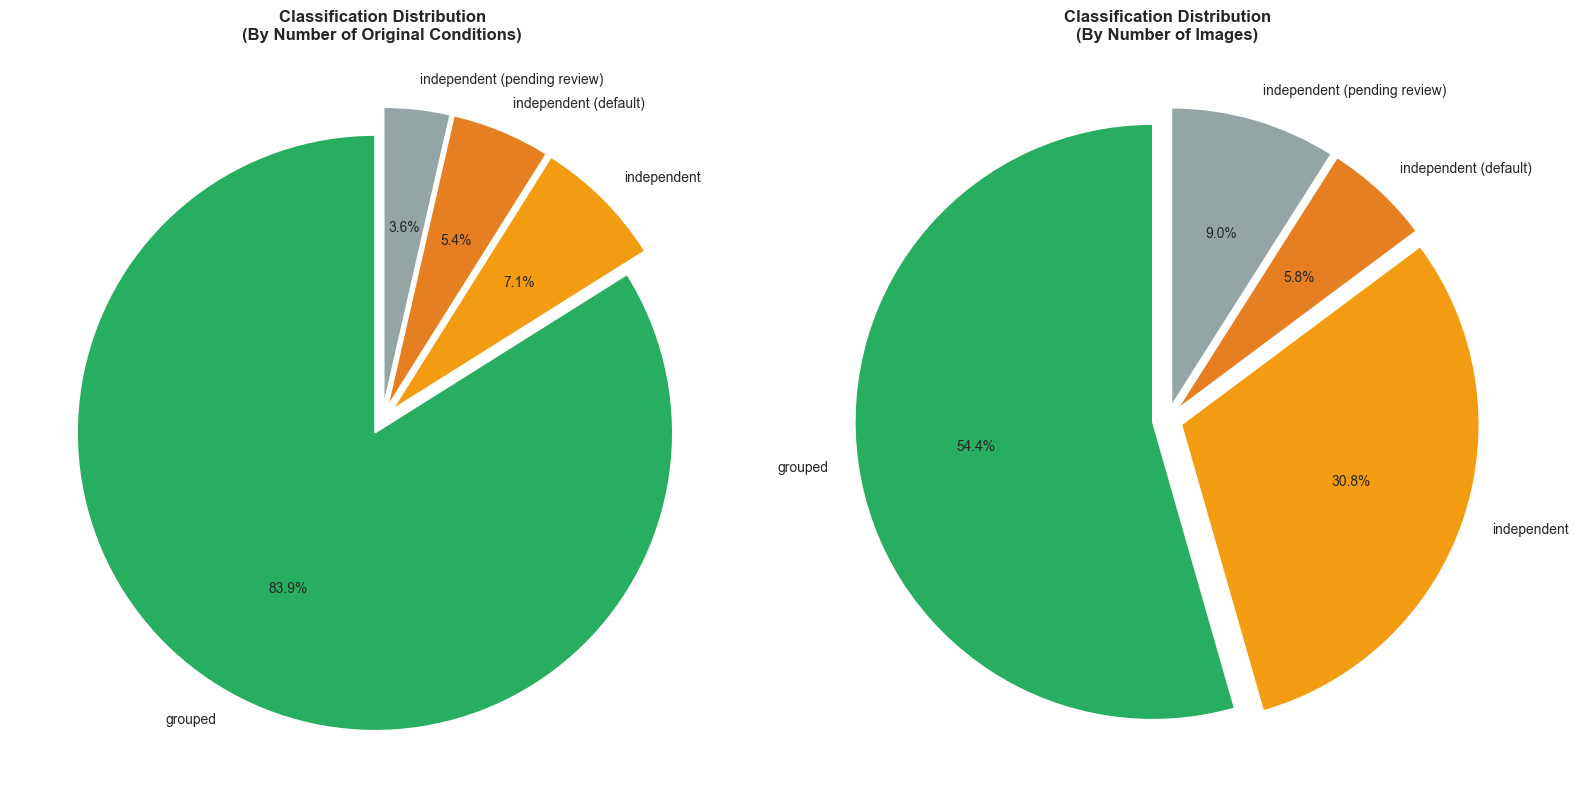

✓ Saved: 08_classification_type_distribution.png


In [41]:
# Visualization 1: Classification type distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: By condition count
type_counts = final_mapping_df['class_type'].value_counts()
colors1 = ['#27ae60', '#f39c12', '#e67e22', '#95a5a6']

axes[0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%',
           colors=colors1, startangle=90, explode=[0.05]*len(type_counts))
axes[0].set_title('Classification Distribution\n(By Number of Original Conditions)', 
                 fontsize=12, weight='bold')

# Plot 2: By image count
type_images = final_mapping_df.groupby('class_type')['original_sample_count'].sum()
axes[1].pie(type_images.values, labels=type_images.index, autopct='%1.1f%%',
           colors=colors1, startangle=90, explode=[0.05]*len(type_images))
axes[1].set_title('Classification Distribution\n(By Number of Images)', 
                 fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '08_classification_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 08_classification_type_distribution.png")

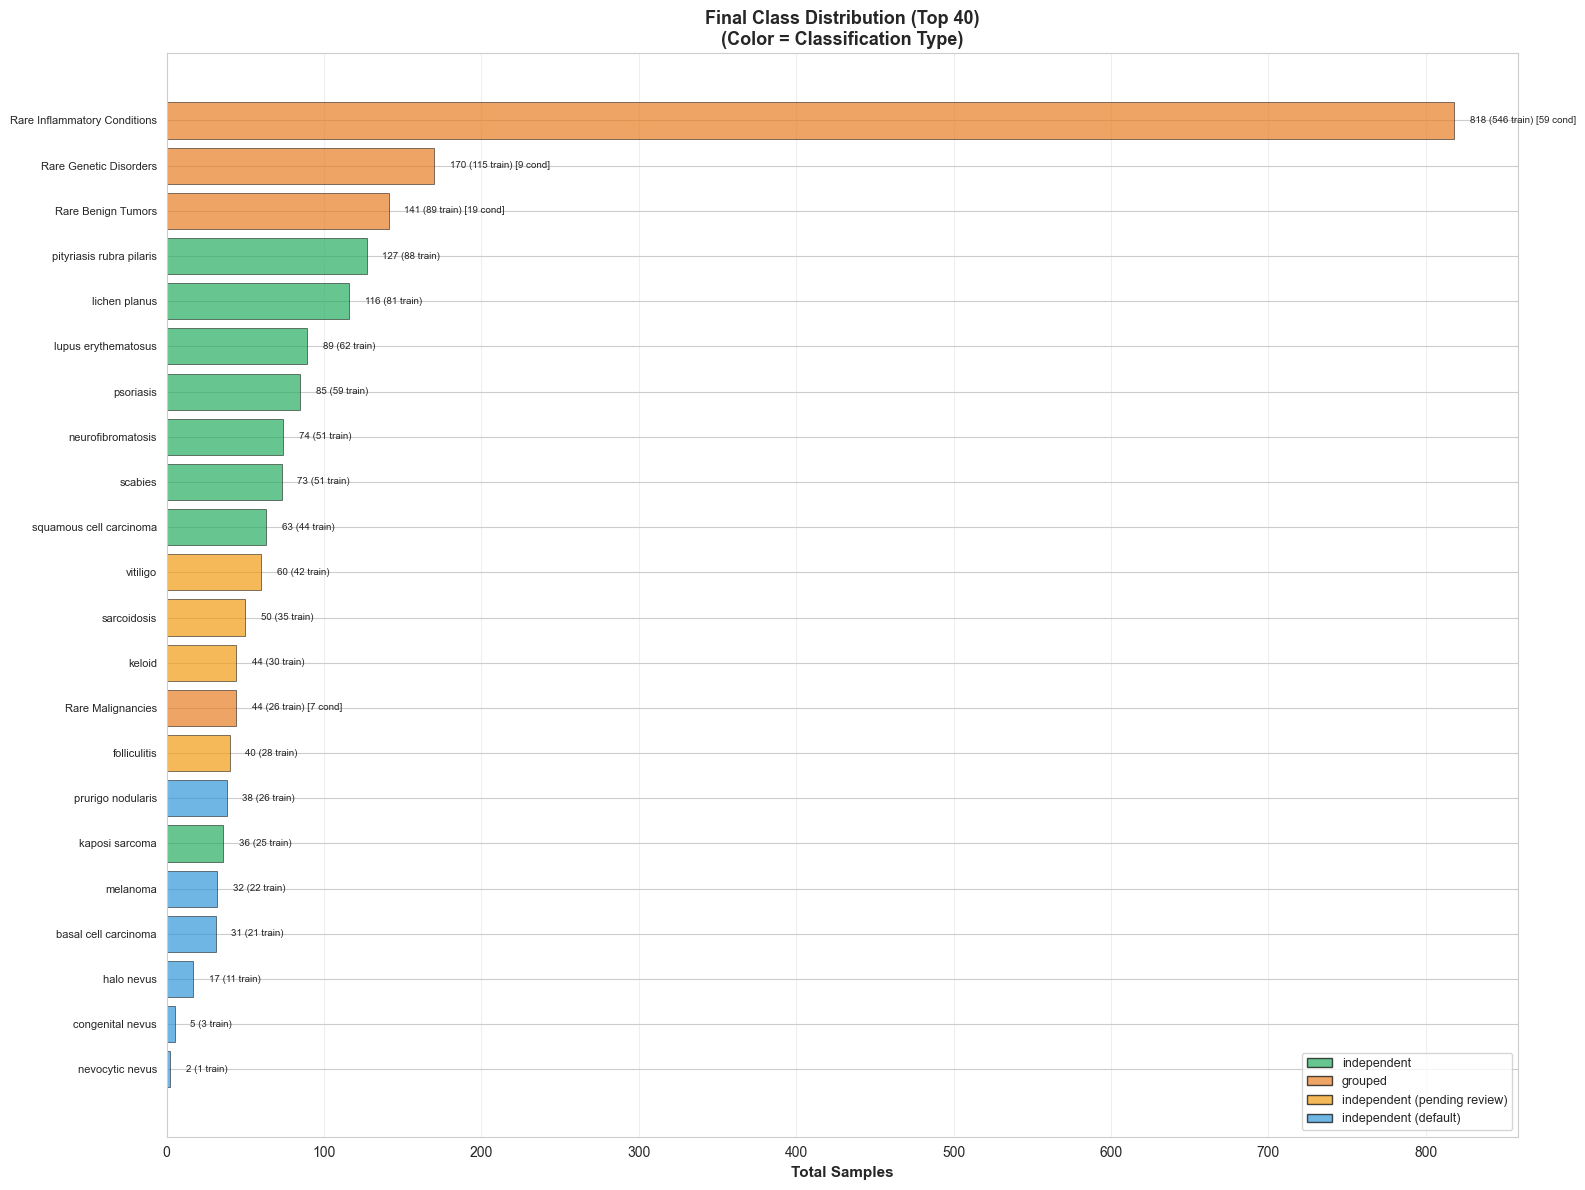

✓ Saved: 09_final_class_distribution.png


In [42]:
# Visualization 2: Final class distribution
fig, ax = plt.subplots(figsize=(16, 12))

# Show top 40 final classes (or all if less than 40)
top_classes = final_classes.head(min(40, len(final_classes)))

# Color by type
type_colors_map = {
    'independent': '#27ae60',
    'grouped': '#e67e22',
    'independent (pending review)': '#f39c12',
    'independent (default)': '#3498db'
}
colors = [type_colors_map.get(t, '#95a5a6') for t in top_classes['class_type']]

bars = ax.barh(range(len(top_classes)), top_classes['original_sample_count'], 
              color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(top_classes)))
ax.set_yticklabels(top_classes.index, fontsize=8)
ax.set_xlabel('Total Samples', fontsize=11, weight='bold')
ax.set_title('Final Class Distribution (Top 40)\n(Color = Classification Type)', 
            fontsize=13, weight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, alpha=0.7, edgecolor='black', label=class_type)
                  for class_type, color in type_colors_map.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

# Add value labels
for bar, (final_class, row) in zip(bars, top_classes.iterrows()):
    width = bar.get_width()
    num_conds = row['num_original_conditions']
    train = row['train_samples']
    label = f"{int(width)} ({int(train)} train)"
    if num_conds > 1:
        label += f" [{int(num_conds)} cond]"
    ax.text(width + 10, bar.get_y() + bar.get_height()/2,
           label, va='center', fontsize=7)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '09_final_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 09_final_class_distribution.png")

## FINAL RECOMMENDATIONS

### Summary

This analysis has systematically evaluated all 112 conditions in the dataset and proposed a classification system that balances:
1. **Clinical validity** - Preserves diagnostically distinct conditions
2. **Training viability** - Ensures adequate samples per class
3. **Rwanda priorities** - Maintains locally-relevant conditions
4. **Malignancy focus** - Careful handling of cancer detection

### Key Decisions Made

1. **"Inflammatory" Category Split**: The dominant inflammatory category (1,502 images) has been analyzed for potential splitting into ~5-8 independent classes plus grouped rare conditions.

2. **Malignancy Handling**: Major cancers (melanoma, SCC, BCC, Kaposi) maintained as independent. Ultra-rare malignancies grouped with documentation of limitations.

3. **Rwanda Priorities**: Conditions like scabies, keloid, folliculitis, and SCC are flagged for independent classification where training-viable.

4. **Grouping Strategy**: Small-sample conditions grouped by clinical similarity (e.g., "Rare Genetic Disorders", "Rare Inflammatory Conditions").

### Critical Next Steps

**⚠️ BEFORE IMPLEMENTATION:**
1. **Dermatology Expert Review**: All classification decisions must be validated by domain expert
2. **Visual Similarity Assessment**: Proposed groupings should be verified with actual image review
3. **Clinical Impact Analysis**: Assess diagnostic implications of grouping decisions
4. **Ethics Review**: Especially for rare malignancy groupings

### Output Files Generated

**CSV Files:**
- `condition_inventory_full.csv` - Complete 112-condition inventory
- `inflammatory_breakdown.csv` - Inflammatory category analysis
- `malignant_conditions_decisions.csv` - All malignant conditions
- `rwanda_priority_conditions.csv` - Rwanda-relevant conditions
- `all_conditions_decisions.csv` - Systematic decisions for all 112
- `condition_classification_mapping.csv` - **FINAL MAPPING (112 → Final Classes)**
- `final_class_statistics.csv` - Aggregated statistics

**Visualizations:**
- `01_top30_conditions.png`
- `06_inflammatory_breakdown.png`
- `07_malignancy_analysis.png`
- `08_classification_type_distribution.png`
- `09_final_class_distribution.png`

### Usage

The `condition_classification_mapping.csv` file is the definitive reference for:
1. Data augmentation notebook (which classes need augmentation)
2. Model training (which labels to use)
3. Evaluation metrics (how to group predictions)
4. Clinical deployment (how to interpret model outputs)

**This classification system should be treated as a living document** - adjust based on expert feedback and early training results.